<a href="https://colab.research.google.com/github/Joonqi/SC2_RotateDetection/blob/main/RotateDetect_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC2 Project - with Lomin
## 합성 데이터를 이용한 문서의 회전 각도 예측 모델 학습

# 1. Build Model

## Reference
#### RepVGG model
```
https://github.com/DingXiaoH/RepVGG
@article{ding2021repvgg,
title={RepVGG: Making VGG-style ConvNets Great Again},
author={Ding, Xiaohan and Zhang, Xiangyu and Ma, Ningning and Han, Jungong and Ding, Guiguang and Sun, Jian},
journal={arXiv preprint arXiv:2101.03697},
year={2021}
}
```
#### for SEBlock
```
https://openaccess.thecvf.com/content_cvpr_2018/html/Hu_Squeeze-and-Excitation_Networks_CVPR_2018_paper.html
```

In [ ]:
import os
import PIL
import json
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import pandas as pd

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                    kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class SEBlock(nn.Module):
    def __init__(self, input_channels, internal_neurons):
        super(SEBlock, self).__init__()
        self.down = nn.Conv2d(in_channels=input_channels, out_channels=internal_neurons, kernel_size=1, stride=1, bias=True)
        self.up = nn.Conv2d(in_channels=internal_neurons, out_channels=input_channels, kernel_size=1, stride=1, bias=True)
        self.input_channels = input_channels
    def forward(self, inputs):
        x = F.avg_pool2d(inputs, kernel_size=inputs.size(3))
        x = self.down(x)
        x = F.relu(x)
        x = self.up(x)
        x = torch.sigmoid(x)
        x = x.view(-1, self.input_channels, 1, 1)
        return inputs * x

class RepVGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, 
                dilation=1, groups=1, padding_mode='zeros', deploy=False, use_se=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels
        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2
        self.nonlinearity = nn.ReLU()
        if use_se:
            self.se = SEBlock(out_channels, internal_neurons=out_channels//16)
        else:
            self.se = nn.Identity()
        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=kernel_size, stride=stride, padding=padding, 
                                dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)
        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels==in_channels and stride==1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)

    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.se(self.rbr_reparam(inputs)))
            
        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)
        return self.nonlinearity(self.se(self.rbr_dense(inputs)+self.rbr_1x1(inputs)+id_out))

In [ ]:
class RepVGG(nn.Module):
    def __init__(self, num_blocks, num_classes=360, width_multiplier=None, override_groups_map=None,
                deploy=False, use_se=False):
        super(RepVGG, self).__init__()
        
        assert len(width_multiplier) == 4
        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()
        self.use_se = use_se
        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64*width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy, use_se=self.use_se)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64*width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        # self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear1 = nn.Linear(20480, 2048)
        # self.dropout = nn.Dropout(0.4)
        self.linear2 = nn.Linear(2048, num_classes)
    
    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                        stride=stride, padding=1, groups=cur_groups, deploy=self.deploy, use_se=self.use_se))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

In [ ]:
def create_RepVGG_A0se(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=360,
                width_multiplier=[.75, .75, .75, 2.5], override_groups_map=None, deploy=deploy, use_se=True)

# 2. Load Trained Weights  
The model is already trained with augmented images data.  
Trained with:  
- 10,000 train samples, 1948 validation samples
- Adam optimizer w/ 0.0001 Learning rate
- 1e-5 Weight decay, 0.4 Dropout (last FC layer)
- 150 epochs
- Resize 320, Centercrop 128
- Augmentation using Centercrop, RandomBrightness, RandomContrast, RandomHue, Grayscale


In [ ]:
# 학습이 완료된 모델 가중치 로드
def load_checkpoint(model, ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    if 'model' in checkpoint:
        checkpoint = checkpoint['model']
    if 'state_dict' in checkpoint:
        checkpoint = checkpoint['state_dict']
    ckpt = {}
    for k, v in checkpoint.items():
        if k.startswith('module.'):
            ckpt[k[7:]] = v
        else:
            ckpt[k] = v
    model.load_state_dict(ckpt)

checkpoint = '/content/drive/MyDrive/LOMIN/RepVGG-A0se_nograyfortest_.pth.tar'
model = create_RepVGG_A0se()
# model.cuda()
load_checkpoint(model, checkpoint)
print(model)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =

In [ ]:
param = {}
param['test_sample'] = '/content/drive/MyDrive/LOMIN/data/test_samples/easyset/'
param['test_data'] = '/content/drive/MyDrive/LOMIN/data/test_data/'
param['display_sample'] = '/content/drive/MyDrive/LOMIN/data/display_sample/'
param['resize'] = 320
param['resolution'] = 128

# 3. Load Dataset

In [ ]:
# 데이터셋 로드
class SampleTestset(torch.utils.data.Dataset):
  def __init__(self, file_path, transform, param):
    self.file_list = [file_path+f for f in os.listdir(file_path)] * 360
    self.transform = transform
    self.resize = param['resize']
  def __len__(self):
    return len(self.file_list)
  def __getitem__(self, index):
    image = self.file_list[index]
    angle = index//4
    image = PIL.Image.open(image).convert('RGB')
    image = image.resize((self.resize, self.resize))
    image = image.rotate(angle)
    image = self.transform(image)
    return image, angle

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, transform, param):
        self.file_list = [file_path+f for f in os.listdir(file_path)]
        self.transform = transform
        self.resize = param['resize']
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, index):
        image = self.file_list[index]
        image = PIL.Image.open(image).convert('RGB')
        # width, height = image.size
        # if width >= height:
        #   image = image.crop((width//5, 0, 4*width//5, height))
        # else:
        #   image = image.crop((0, height//5, width, 4*height//5))
        image = image.resize((self.resize, self.resize), resample=PIL.Image.LANCZOS, reducing_gap=3)
        image = self.transform(image)
        angle = 0
        return image, angle

def get_test_dataset(param, trans):
    testdir = os.path.join(param['test_data'], '')
    test_dataset = TestDataset(testdir, trans, param)
    return test_dataset

def get_test_loader(param):
    test_trans = get_val_trans(param)
    test_dataset = get_test_dataset(param, test_trans)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=32, shuffle=False,
        num_workers=2, pin_memory=True)
    return test_loader

def get_val_trans(param):
    transform = tfs.Compose([
        tfs.CenterCrop(param['resolution']),
        tfs.ToTensor(),
        tfs.Normalize([.5, .5, .5], [.5, .5, .5])
        ])
    return transform

# 4. Evaluate Model for Sample Test data

In [ ]:
# Test sample -> Accuracy Check
# 4장의 이미지를 각각 0~359도 회전 -> 총 1440장의 이미지
model.eval()
test_trans = get_val_trans(param)
sample_dataset = SampleTestset(param['test_sample'], test_trans, param)
test_loader = torch.utils.data.DataLoader(
    sample_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
labels, pred = [], []
with torch.no_grad():
    for i, (images, target) in enumerate(test_loader):
      # images = images.cuda()
      output = model(images)
      _, predict = output.max(1)
      labels.extend(target.tolist())
      pred.extend(predict.tolist())

In [ ]:
y_t = pd.Series(labels)
y_p = pd.Series(pred)
diff = abs(y_t - y_p)

print('Accurate   :', round(len(diff[diff==0])/len(diff), 4))
print('Error in 3 :', round(len(diff[(diff<=3)|(diff>=357)])/len(diff),4))

Accurate   : 0.3472
Error in 3 : 0.6806


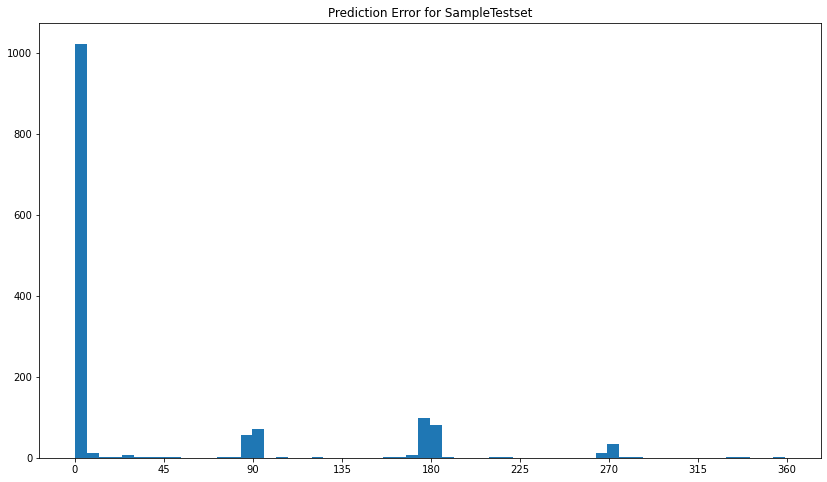

In [ ]:
plt.figure(figsize=(14, 8))
plt.hist(diff, bins=60)
plt.title('Prediction Error for SampleTestset')
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.yticks([0, 200, 400, 600, 800, 1000])
plt.show()

# 5. Real Test Sample

In [ ]:
model.eval()
test_trans = get_val_trans(param)
disp_sample_dataset = TestDataset(param['display_sample'], test_trans, param)
disp_test_loader = torch.utils.data.DataLoader(
    disp_sample_dataset, shuffle=False, num_workers=2, pin_memory=True)
dis_predict = []
with torch.no_grad():
    for i, (images, target) in enumerate(disp_test_loader):
      output = model(images)
      _, disp_predicted = output.max(1)
      dis_predict.extend(disp_predicted.tolist())

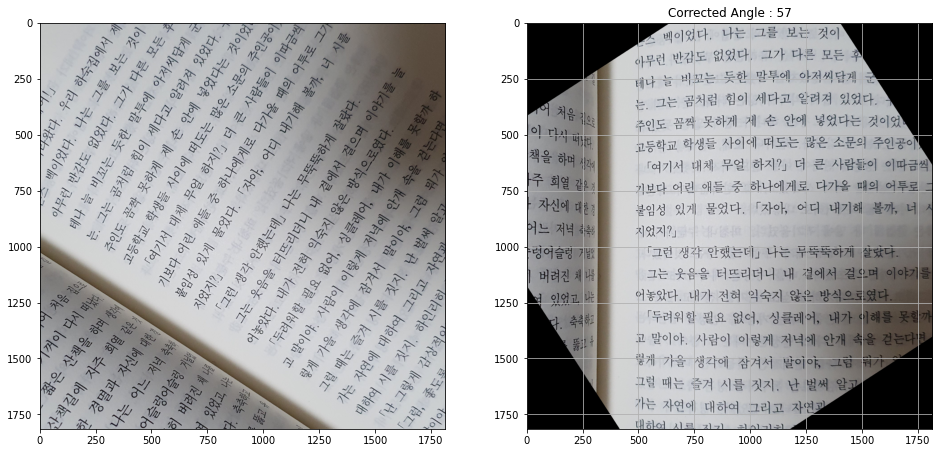

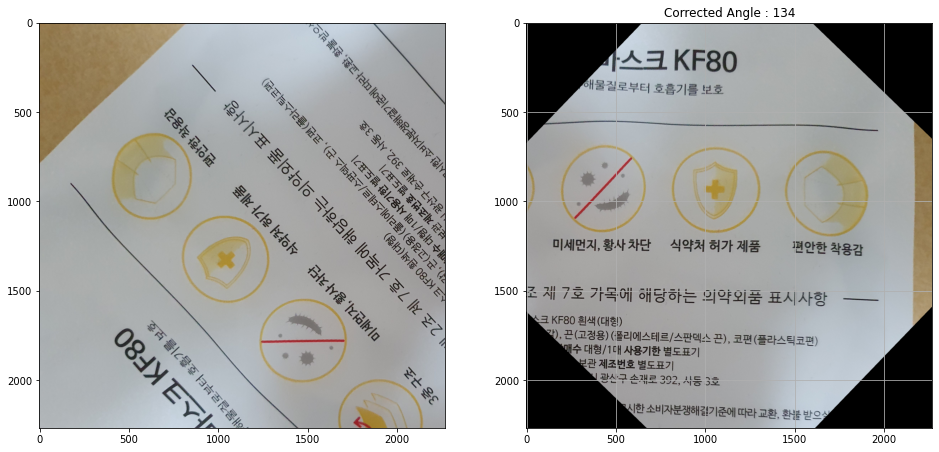

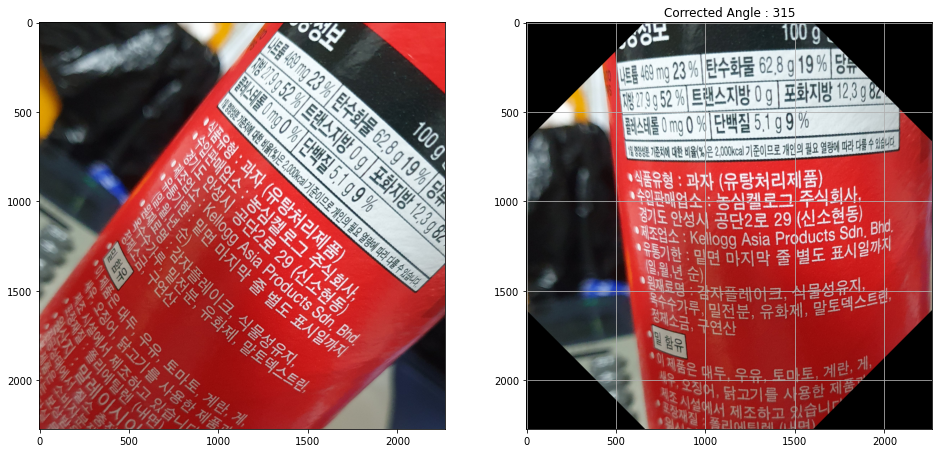

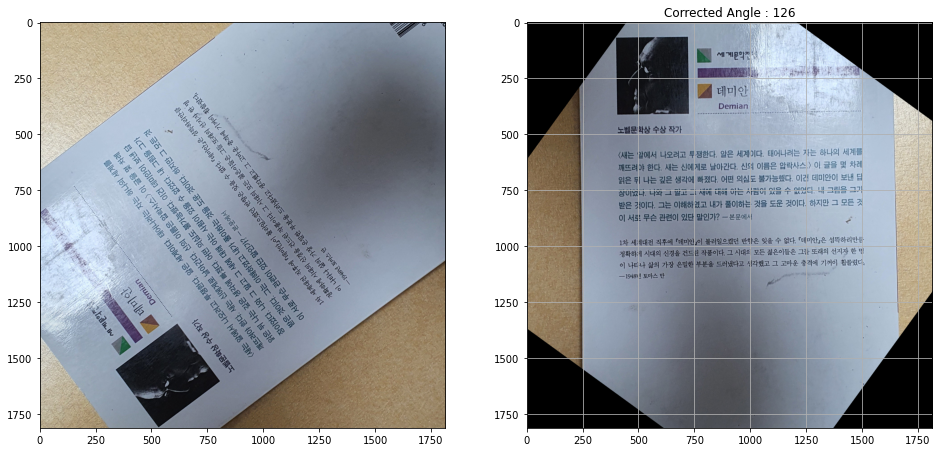

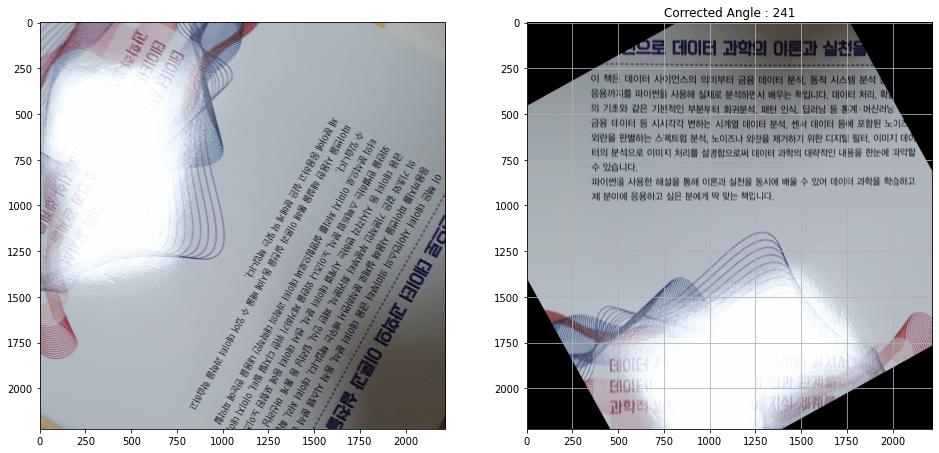

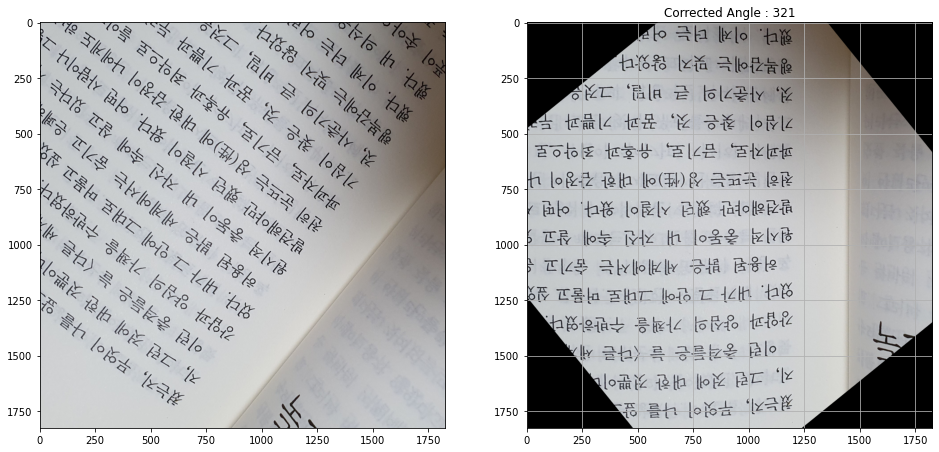

In [ ]:
file_path = param['display_sample']
file_list = [file_path+f for f in os.listdir(file_path)]
for i, (file, angle) in enumerate(zip(file_list, dis_predict)):
  image = PIL.Image.open(file).convert('RGB')
  rotate = image.rotate(-angle)
  plt.figure(figsize=(16, 8))
  plt.subplot(121)
  plt.imshow(image)
  plt.subplot(122)
  plt.imshow(rotate)
  plt.title('Corrected Angle : {}'.format(angle))
  plt.grid(True)
  plt.show()